In [382]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import os
from os.path import join
from os import getcwd
from pathlib import Path
from sys import path

from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Oversampling
# Ref: https://arxiv.org/pdf/1106.1813.pdf
from imblearn.over_sampling import SMOTE

#Hyperparameter Optimization
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Set Functions to Path
full_path = os.getcwd()
functions_path = join( Path(full_path).parents[0].parents[0].parents[0] )
path.append( functions_path  )

# Tensortrader functions
from utils.utils import *
from ML.label_methods import *
from ETL.ETL_func import *
from Features import feature_generation as fe

from datetime import datetime 
import os
import logging
import dateutil
import yaml

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [383]:
SYMBOLS

['BNBUSDT',
 'BNBBTC',
 'BTCUSDT',
 'EOSUSDT',
 'ETCUSDT',
 'LTCUSDT',
 'XMRBTC',
 'TRXUSDT',
 'XLMUSDT',
 'ADAUSDT',
 'IOTAUSDT',
 'MKRUSDT',
 'DOGEUSDT',
 'ETHUSDT']

In [395]:
def test(**args):
    add_params = {}
    for key , value in args.items():
        print("key: ", key, " value", value)
        add_params[key] = value
        

In [396]:
test(val1 = 1, val2 = 2, val3 = 3)

key:  val1  value 1
key:  val2  value 2
key:  val3  value 3


# 1. Data Load

In [347]:
datetime.today()

datetime.datetime(2022, 6, 11, 10, 0, 6, 676770)

In [348]:
path_loc = "/mnt/c/Tensor/Database/Cryptos/"
days = 60

SYMBOLS = ['ETHUSDT']

#--------------------------------------------------------------------
# Data Load
#--------------------------------------------------------------------
input_folder_db = os.path.join(path_loc)
initial_date_load = datetime.today() - dateutil.relativedelta.relativedelta(days = days)
years_filter = [2022]

dfs = []

for symbol in SYMBOLS:
    for year in years_filter:

        file_name = os.path.join(input_folder_db, f'{symbol}', f'{year}_{symbol}.parquet'  )
        print("Reading file", file_name)

        df = pd.read_parquet(file_name)
        print(" Max Date is ", df['Date'].max())
        df = df[df['Date'] >= initial_date_load].copy()
        dfs.append(df)

        del df

data = pd.concat(dfs, ignore_index = True).drop_duplicates()

data.loc[:,'timestamp'] = data['Open Time'].copy()
data.set_index('timestamp', inplace = True)
data.sort_values(by = ['timestamp'], inplace = True)

data = (data.groupby(['Ticker'], 
        group_keys= False)
        .apply(reindex_by_date)
        .reset_index())

# Convert Unix timestamp to datetime 
data.loc[:,'timestamp'] = pd.to_datetime(data['timestamp'], unit = "ms") 

data = data.drop(columns = ['max_trades'])

Reading file /mnt/c/Tensor/Database/Cryptos/ETHUSDT/2022_ETHUSDT.parquet
 Max Date is  2022-06-11 13:51:00


In [349]:
data.tail()

,timestamp,Open Time,Open,High,Low,Close,Volume,Clos Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore,Date,Year,Ticker
86626,2022-06-11 13:47:00,1654955220000,1571.22,1571.78,1569.31,1570.54,694.1697,1654955279999,1.090222e+06,784,407.7096,640269.141556,0,2022-06-11 13:47:00,2022,ETHUSDT
86627,2022-06-11 13:48:00,1654955280000,1570.53,1570.57,1566.32,1567.55,671.3118,1654955339999,1.053004e+06,726,325.4157,510266.913410,0,2022-06-11 13:48:00,2022,ETHUSDT
86628,2022-06-11 13:49:00,1654955340000,1567.55,1568.94,1567.29,1568.17,629.1603,1654955399999,9.865562e+05,626,285.6413,447885.284945,0,2022-06-11 13:49:00,2022,ETHUSDT
86629,2022-06-11 13:50:00,1654955400000,1568.16,1570.14,1567.82,1568.50,721.0324,1654955459999,1.131197e+06,664,404.4877,634523.820720,0,2022-06-11 13:50:00,2022,ETHUSDT
86630,2022-06-11 13:51:00,1654955460000,1568.49,1568.50,1566.41,1567.88,366.0809,1654955519999,5.737444e+05,507,138.0228,216294.231050,0,2022-06-11 13:51:00,2022,ETHUSDT


In [350]:
data.shape

(86631, 16)

# 2. Triple Barrier Method Labels

In [351]:
df = data.set_index('timestamp').copy()

ticker = SYMBOLS[0]

# Profit-Stop Loss ratio
ptsl = [3,1]
v_barrier_minutes = 15
delta_vertical_b = pd.Timedelta(minutes = v_barrier_minutes) # Vertical barrier length
#output_folder_db = os.path.join(path_prefix, 'Data/Tensor_Invest_Fund/data/Cryptos/TBM')

# Volatility Parameters
delta_volatility = pd.Timedelta(minutes=1)
span_volatility = 60 # number of candles to considered for volatility

# Position Type
# 1: Long
# -1: Short
pt = 1
n_jobs = -2
max_nbytes = '0.8M'
parallel_calculation = False

TBM_labels = TripleBarrierMethod(df,
                                ticker,
                                ptsl,
                                delta_vertical_b,
                                pt,
                                delta_volatility,
                                span_volatility,
                                n_jobs,
                                parallel_calculation,
                                max_nbytes )

TBM_labels.run()

Getting volatility
Getting horizons
Getting touches
Getting Labels


In [352]:
TBM_labels.data.label.value_counts()

-1    50401
 0    22622
 1    13590
Name: label, dtype: int64

In [355]:
data = TBM_labels.data.copy()

In [356]:
data.columns

Index(['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Clos Time',
       'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume',
       'Taker Buy Quote Asset Volume', 'Ignore', 'Date', 'Year', 'Ticker',
       'threshold', 't1', 'label'],
      dtype='object')

## 2.1 Cost Analysis TBM and Strategy Viability

### 2.1.1 Calculate Metalabels

In [357]:
windows = [15,240]
group_level = ['Ticker']

for window in windows:

    data[f'SMA_{window}'] = data.groupby(group_level)['Close'].transform(lambda x: x.rolling(window = window, closed = 'left').mean())

data = fe.strategy_crossing_sma(data, sma_w = windows)

data.loc[:,'metalabel'] = fe.get_metalabels(y_model1 = data['sma_cross_over'] , y_true = data['label'])

print(data['metalabel'].value_counts())

0.0    86317
1.0      296
Name: metalabel, dtype: int64


In [359]:
# Analize TBM and Metalabel performance only in test data set
split_percentage = 0.7
split = int(split_percentage*len(data))

# Vectorized Backtesting
cols = ['Date', 'Close','Volume', 'label', 'sma_cross_over', 'metalabel']
tbm_backtest_df = data[split:].filter(cols).copy()

#tbm_backtest_df.loc[:,'tbm_adj'] = adj_ml_strategy(tbm_backtest_df.tbm.values, v_barrier_minutes)

tbm_backtest_df.reset_index(inplace = True)

In [360]:
data.columns

Index(['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Clos Time',
       'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume',
       'Taker Buy Quote Asset Volume', 'Ignore', 'Date', 'Year', 'Ticker',
       'threshold', 't1', 'label', 'SMA_15', 'SMA_240', 's_sma_<_l_sma',
       's_sma_<_l_sma_lag1', 'cross', 'sma_cross_over', 'metalabel'],
      dtype='object')

In [364]:
tbm_backtest_df.loc[:,'Return'] = tbm_backtest_df['Close'].pct_change(1)
tbm_backtest_df.loc[:,"metalabel_adj"]  = adj_ml_strategy(tbm_backtest_df['metalabel'], v_barrier_minutes )

tbm_backtest_df.loc[:,"strategy"] = tbm_backtest_df['label'].shift(1)* tbm_backtest_df['Return']
#tbm_backtest_df.loc[:,"strategy_sma"] = tbm_backtest_df['sma_cross_over'].shift(1)* tbm_backtest_df['Return']
tbm_backtest_df.loc[:,"strategy_meta"] = tbm_backtest_df.loc[:,"metalabel_adj"].shift(1)* tbm_backtest_df['Return']


tbm_backtest_df.loc[:,"buy_hold"] = tbm_backtest_df["Return"].cumsum().apply(np.exp)
tbm_backtest_df.loc[:,"ml_strategy"] = tbm_backtest_df["strategy"].cumsum().apply(np.exp)
tbm_backtest_df.loc[:,"ml_strategy_meta"] = tbm_backtest_df["strategy_meta"].cumsum().apply(np.exp)

# Cost Analysis
# TODO: Spread Analysis of every coin
dec_points = len(str(tbm_backtest_df['Close'].values[0]).split(".")[1])
spread = 2 * 1 / (10 ** dec_points) # pips == fourth price decimal
half_spread = spread / 2 # absolute tc per trade (position change +-1)
ptc = half_spread / tbm_backtest_df.Close.mean() # proportional tc per trade (position change +-1)

# Binance Fee
bc = 0.001

ptc += bc

In [365]:
# Number of trades for pure ml strategy
tbm_backtest_df["n_trader_ml"] = tbm_backtest_df['label'].diff().fillna(0).abs()

# Number of trades ml strategy adjusted
# Changing from 1 position to another one counts as two  trades
tbm_backtest_df["n_trader_ml_sma"] = tbm_backtest_df['metalabel_adj'].diff().fillna(0).abs() 

# Include Spread cost
tbm_backtest_df['cost_ml'] = tbm_backtest_df.n_trader_ml * ptc
tbm_backtest_df['cost_ml_sma'] = tbm_backtest_df.n_trader_ml_sma * ptc

tbm_backtest_df['cost_ml_USDT'] = tbm_backtest_df.cost_ml * tbm_backtest_df.Close
tbm_backtest_df['cost_ml_sma_USDT'] = tbm_backtest_df.cost_ml_sma * tbm_backtest_df.Close

tbm_backtest_df['ml_strategy_c'] = tbm_backtest_df.strategy - tbm_backtest_df.cost_ml
tbm_backtest_df['ml_strategy_meta_c'] = tbm_backtest_df.strategy_meta - tbm_backtest_df.cost_ml_sma

# Calculate Net Profit
tbm_backtest_df['ml_strategy_net'] = tbm_backtest_df.ml_strategy_c.cumsum().apply(np.exp)
tbm_backtest_df['ml_strategy_meta_net'] = tbm_backtest_df.ml_strategy_meta_c.cumsum().apply(np.exp)


initial_investment = tbm_backtest_df.iloc[0]['Close']


final_return = tbm_backtest_df.iloc[-1]['ml_strategy_net']
final_investment = initial_investment * (1+final_return)
total_trading_cost = tbm_backtest_df['cost_ml_USDT'].sum()
performance_ml = final_investment   

print("ML: Saldo after Backtesting for trading size 1 unit of the Coin $USD", np.round(performance_ml, 2), " N Trades: ", tbm_backtest_df.n_trader_ml.sum()/2, "Cost:", total_trading_cost )

final_return = tbm_backtest_df.iloc[-1]['ml_strategy_meta_net']
final_investment = initial_investment*(1+final_return)
total_trading_cost = tbm_backtest_df['cost_ml_sma_USDT'].sum()
performance_ml = final_investment 

print("ML ADJ: Saldo after Backtesting for trading size 1 unit of the Coin $USD", np.round(performance_ml, 2), " N Trades: ", tbm_backtest_df.n_trader_ml_sma.sum()/2, "Cost:", total_trading_cost )

ML: Saldo after Backtesting for trading size 1 unit of the Coin $USD 7045.85  N Trades:  2975.5 Cost: 10933.827605216316
ML ADJ: Saldo after Backtesting for trading size 1 unit of the Coin $USD 3341.93  N Trades:  176.0 Cost: 649.2172607496566


In [366]:
tbm_backtest_df['metalabel_adj'].value_counts()

 0    25808
 1       88
-1       88
Name: metalabel_adj, dtype: int64

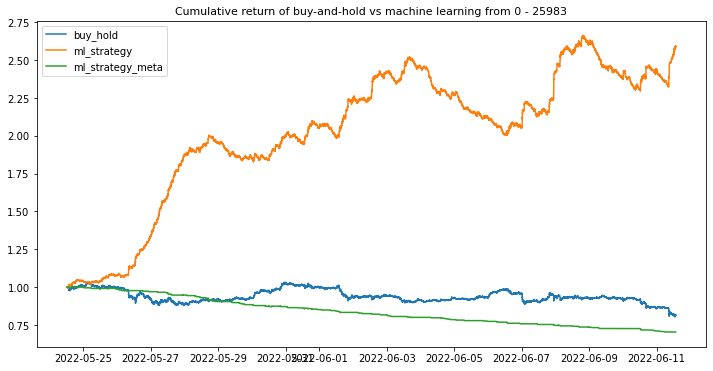

In [368]:
plt.figure(figsize=(12, 6))
plt.plot(tbm_backtest_df.Date, tbm_backtest_df["buy_hold"])

plt.plot(tbm_backtest_df.Date, tbm_backtest_df["ml_strategy_net"])
plt.plot(tbm_backtest_df.Date, tbm_backtest_df["ml_strategy_meta_net"])
plt.legend(["buy_hold", "ml_strategy", "ml_strategy_meta"])
plt.title(f"Cumulative return of buy-and-hold vs machine learning from {tbm_backtest_df.index[0]} - {tbm_backtest_df.index[-1]}", fontsize=11)
plt.show()


In [369]:
# Define section to filter for TBM Strategies with a total potential of return greater than 1.5

# 3. Feature Engineering

In [370]:
CONF = yaml.safe_load(Path('../../../config.yml').read_text())

In [371]:
# Feature Configuration ID
feature_id = 1

# Strategy
strategy = '1-1_vb_15m' # '2-1_vb_15m' or 2-2_vb_15m

# -------------------------------------------------------
# Features Calculation
# -------------------------------------------------------

# Features Configuration
features_conf = CONF['Feature_Engineering'][feature_id]

# (1) Calculate Technical Indicators
ta_config = features_conf['ta']
data = fe.calculate_technical_indicators(data, features_conf, SYMBOLS)

# (2) Calculate Lag Features
if features_conf['include_lags']:
    data = fe.calculate_lag_features(data, features_conf, SYMBOLS)

# (3) Calculate Return Features
if features_conf['Return_Features']:
    date_col = 'Date'
    data = fe.calculate_returns_per_ticker(data, features_conf, SYMBOLS, date_col)

# (4) Momemtum Features
if features_conf['Return_Features'] and features_conf['Momentum_Features']:
    data = fe.calculate_momemtum_features(data, features_conf, SYMBOLS)

# (5) Time Features
if features_conf['Time_Features']:

    time_levels =  ['month', 'day', 'hour', 'minute']
    timestamp_col = 'Date'
    data = fe.build_time_columns(data, timestamp_col, time_levels)

    if features_conf['Time_Fourier_Features']:                    
        data = fe.build_fourier_time_features(data, time_levels = ['month', 'day', 'hour', 'minute'], max_levels = [12, 30, 24, 60], drop_columns = True)

# (6) Volume Features
if features_conf['Volume_Features']:
    group_level = ['Ticker']
    data = fe.calculate_volume_features(data, group_level, features_conf)

# (7) Apply Standard Scaler
if features_conf['Apply_Standard_Scaler']:

    if features_conf['Apply_Standard_Scaler_Lags']:

        cols_to_add = []
        for lag_variable in features_conf['ref_variable_lags']:
            for lag in features_conf['lags']:
                cols_to_add.append(f'{lag_variable}_lag_{lag}')


        cols = features_conf['Standard_Scaler_Cols'] + cols_to_add
    else:
        cols = features_conf['Standard_Scaler_Cols']

    print(cols)

    for col in cols:
        data.loc[:,f'{col}_standard'] = data.groupby('Ticker')[col].transform(lambda x: fe.apply_standard_scaler(x))
        
# windows = [10,120]
# group_level = ['Ticker']

# for window in windows:

#     data[f'SMA_{window}'] = data.groupby(group_level)['Close'].transform(lambda x: x.rolling(window = window, closed = 'left').mean())

# data = fe.strategy_crossing_sma(data, sma_w = windows)

# data.loc[:,'metalabel'] = fe.get_metalabels(y_model1 = data['sma_cross_over'] , y_true = data['label'])

# print(data['metalabel'].value_counts())


Calculating Technical Indicators for ticker ETHUSDT
Calculating lags for ticker ETHUSDT
Calculating returns for ticker ETHUSDT
['Volume', 'Number of Trades']


In [372]:
data['label'].value_counts()

-1    50258
 0    22568
 1    13547
Name: label, dtype: int64

# 4. Model Training

In [373]:
data.columns

Index(['Date', 'Open Time', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Clos Time', 'Quote Asset Volume', 'Number of Trades',
       'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume', 'Ignore',
       'Year', 'Ticker', 'threshold', 't1', 'label', 'SMA_15', 'SMA_240',
       's_sma_<_l_sma', 's_sma_<_l_sma_lag1', 'cross', 'sma_cross_over',
       'metalabel', 'SMA_120', 'VWMA_60', 'VWMA_15', 'BBL_15_2.0',
       'BBM_15_2.0', 'BBU_15_2.0', 'BBB_15_2.0', 'BBP_15_2.0', 'BBL_120_2.0',
       'BBM_120_2.0', 'BBU_120_2.0', 'BBB_120_2.0', 'BBP_120_2.0',
       'MACD_15_120_9', 'MACDh_15_120_9', 'MACDs_15_120_9', 'RSI_15',
       'ATRr_15', 'PDIST', 'Close_lag_1', 'Close_lag_3', 'Close_lag_5',
       'Close_lag_15', 'Close_lag_30', 'Close_return_1m', 'Close_return_5m',
       'Close_return_15m', 'Close_return_60m', 'Close_return_240m', 'month',
       'day', 'hour', 'minute', 'Volume_sma_5', 'Volume_sma_30',
       'Volume_std_5', 'Volume_std_30', 'Volume_standard',
       'N

In [374]:
data_org = data.copy()

In [375]:
predictors_list = ['SMA_15', 'SMA_120',
       'VWMA_60', 'VWMA_15', 'BBL_15_2.0', 'BBM_15_2.0', 'BBU_15_2.0',
       'BBB_15_2.0', 'BBP_15_2.0', 'BBL_120_2.0', 'BBM_120_2.0', 'BBU_120_2.0',
       'BBB_120_2.0', 'BBP_120_2.0', 'MACD_15_120_9', 'MACDh_15_120_9',
       'MACDs_15_120_9', 'RSI_15', 'ATRr_15', 'PDIST', 'Close_lag_1',
       'Close_lag_3', 'Close_lag_5', 'Close_lag_15', 'Close_lag_30',
       'Close_return_1m', 'Close_return_5m', 'Close_return_15m',
       'Close_return_60m', 'Close_return_240m', 'month', 'day', 'hour',
       'minute', 'Volume_sma_5', 'Volume_sma_30', 'Volume_std_5',
       'Volume_std_30', 'Volume_standard', 'Number of Trades_standard'
]

# Take a sample of the data set
sample_size = 0.3
split_percentage = 1 - sample_size

split = int(split_percentage*len(X))

model_data = data[split:].copy()    

model_data = data.dropna()

print("Dataset size", data.shape)

X = model_data[predictors_list]

# Learn only the long entries
#y = data.label.map({-1:0, 0:0, 1:1})
y = model_data.label.map({-1:0, 0:1, 1:2})

test_size = 300
n_splits = 3
max_train_size = None
gap = 2

# oversampleing or class_weights
imbalance_classes_mode = "class_weights"

# Create Temporal Cross Validation Object
tscv = TimeSeriesSplit(n_splits = n_splits, 
                      max_train_size  = max_train_size, 
                      test_size = test_size, 
                      gap = gap)

max_learning_rate = 0.05
max_max_depth = 50
max_n_estimators = 500

param_grid = {
              'learning_rate': Real(0.005, max_learning_rate, prior='log-uniform'),
              'max_depth': Integer(3, max_max_depth, prior='log-uniform'),
              'n_estimators': Integer(10, max_n_estimators, prior='log-uniform'),
            #   'gamma': Real(0.1, 0.3, prior='log-uniform'),
            #   'reg_alpha': Real(0.01, 1.6, prior='log-uniform'),
            #   'reg_lambda': Real(0.01, 1.6, prior='log-uniform'),
            #   'min_child_weight': Real(0.01, 5, prior='log-uniform'),
            #   'max_delta_step' : Real(0.01, 5, prior='log-uniform')
               }

# ---------------------------------------------- #
# Experiment Parameters 
# ---------------------------------------------- #
n_jobs = 4
n_iter = 15
random_state = 123

# Split the data into train and test dataset
split_percentage = 0.7

split = int(split_percentage*len(X))

X_train = X[:split]
X_test = X[split:]

y_train = y[:split]
y_test = y[split:]

Dataset size (86373, 64)


In [376]:
if imbalance_classes_mode == "class_weights":

    # Compute class Weights
    classes_weights = compute_class_weight(class_weight =  'balanced', classes = np.unique(y_train), y = y_train )

    #weights = {0: classes_weights[0] , 1: classes_weights[1]}
    weights = {0: classes_weights[0] , 1: classes_weights[1], 2: classes_weights[2]}
    
if imbalance_classes_mode == "oversampleing":
    # Oversampling technique
    sm = SMOTE()
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


### Feature Selection

In [377]:
def feature_selection(predictors_list, X_train, y_train, mode = "mean_decrease" ):
    
    # Ref: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.inspection import permutation_importance

    feature_names = predictors_list
    forest = RandomForestClassifier(random_state=0)
    forest.fit(X_train, y_train)

    if mode == "permutation":

        start_time = time.time()
        result = permutation_importance(
            forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
        )
        elapsed_time = time.time() - start_time
        print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


        # Permutation feature importance
        feat_importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending = False)

    if mode == "mean_decrease":

        # Feature importance based on mean decrease in impurity
        importances = forest.feature_importances_
        std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

        feat_importances = pd.Series(importances, index=feature_names).sort_values(ascending = False)
        
    return feat_importances

In [387]:
X_train

,SMA_15,SMA_120,VWMA_60,VWMA_15,BBL_15_2.0,BBM_15_2.0,BBU_15_2.0,BBB_15_2.0,BBP_15_2.0,BBL_120_2.0,...,month,day,hour,minute,Volume_sma_5,Volume_sma_30,Volume_std_5,Volume_std_30,Volume_standard,Number of Trades_standard
29,3026.101333,3056.024917,3042.987914,3024.160218,3010.264869,3026.101333,3041.937797,1.046658,0.367668,3024.362534,...,4,12,14,33,1072.52948,1027.884700,528.584036,594.678962,0.727481,0.437146
30,3025.718667,3055.767333,3042.449673,3024.065957,3010.377074,3025.718667,3041.060260,1.014079,0.576959,3023.705228,...,4,12,14,34,1104.99094,1040.103050,527.658754,593.415135,0.934906,0.427397
31,3025.283333,3055.583167,3042.059913,3023.992590,3010.923646,3025.283333,3039.643021,0.949312,0.685473,3023.200644,...,4,12,14,35,931.50302,1026.167927,227.166946,586.490663,0.866170,0.983040
32,3024.350000,3055.418000,3041.473950,3023.297271,3013.242777,3024.350000,3035.457223,0.734520,0.705272,3022.696931,...,4,12,14,36,886.62622,956.254220,287.694326,510.457241,0.063432,0.126598
33,3023.514000,3055.236833,3041.000565,3022.888920,3014.875235,3023.514000,3032.152765,0.571439,0.583114,3022.086553,...,4,12,14,37,877.27020,933.758607,298.174593,510.982227,0.168409,0.161413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60464,1956.576667,1963.316083,1959.171153,1954.105620,1948.469328,1956.576667,1964.684005,0.828727,-0.275018,1955.333204,...,5,24,13,48,1537.67002,765.054013,1347.051667,729.273715,4.681811,6.480977
60465,1955.078000,1963.093667,1957.546451,1951.499224,1943.300394,1955.078000,1966.855606,1.204822,-0.203793,1953.931824,...,5,24,13,49,1908.93718,842.978320,1263.797667,776.845115,2.653140,3.400573
60466,1953.622667,1962.872583,1956.253096,1949.497819,1940.250125,1953.622667,1966.995209,1.368999,-0.009726,1952.815487,...,5,24,13,50,2149.71754,914.488603,1196.628183,814.530186,2.570520,3.467417
60467,1952.540667,1962.674833,1955.629894,1948.616465,1938.629835,1952.540667,1966.451498,1.424895,0.166782,1952.033893,...,5,24,13,51,2270.71960,953.103797,1058.271989,812.977992,1.376306,1.354861


In [385]:
y_train

29       1
30       0
31       0
32       0
33       0
        ..
60464    0
60465    0
60466    0
60467    0
60468    0
Name: label, Length: 60440, dtype: int64

In [378]:
feat_importances = feature_selection(predictors_list, X_train, y_train, mode = "mean_decrease" )

In [379]:
feature_selected = list(feat_importances.head(20).index)

In [380]:
feature_selected

['BBB_120_2.0',
 'Volume_std_30',
 'Close_return_240m',
 'Volume_sma_30',
 'ATRr_15',
 'MACDs_15_120_9',
 'BBU_120_2.0',
 'BBP_120_2.0',
 'MACD_15_120_9',
 'BBL_120_2.0',
 'minute',
 'Close_return_60m',
 'MACDh_15_120_9',
 'BBM_120_2.0',
 'VWMA_60',
 'SMA_120',
 'RSI_15',
 'BBB_15_2.0',
 'BBP_15_2.0',
 'hour']

### Model Training

In [381]:
# Create classification tree model
xgb_model = XGBClassifier(objective="multi:softmax", 
                                booster='gbtree',
                                eval_metric='auc', 
                                grow_policy='lossguide')


bayes_search = BayesSearchCV(
    xgb_model,
    param_grid,
    n_iter = n_iter,
    random_state = random_state,
    n_jobs = n_jobs,
    cv = tscv
)

if imbalance_classes_mode == "class_weights":
    model = bayes_search.fit(X_train.filter(feature_selected), y_train, sample_weight = pd.Series(y_train).map(weights) ) 

if imbalance_classes_mode == "oversampleing":
    model = bayes_search.fit(X_train_res.filter(feature_selected), y_train_res)

# Predict training set
y_pred = model.predict(X_test.filter(feature_selected))

#print(Y_pred)

KeyboardInterrupt: 

In [ ]:
# Test accuracy
accuracy_test = accuracy_score(y_test, y_pred)
print("accuracy score:", round(accuracy_test, 4))

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

# 5. Backtesting

## 5.1 Vectorized Backtesting

In [287]:
# Vectorized Backtesting
cols = ['Date', 'Close','Volume']
backtest_df = data[split:].filter(cols).copy()
#backtest_df.loc[:,"pred"] = pd.Series(y_pred).values
backtest_df.loc[:,"pred"] = pd.Series(y_pred).map({0:-1,1:0,2:1}).values
backtest_df.reset_index(inplace = True, drop = True)

In [288]:
backtest_df['pred'].value_counts()

 0    3192
 1    1675
-1     933
Name: pred, dtype: int64

In [332]:
# Adjust trading signals
backtest_df['pred_adj'] = pd.Series(adj_ml_strategy(backtest_df.pred.values, v_barrier_minutes))

#pd.Series(adj_ml_strategy(backtest_df.pred.values, v_barrier_minutes))   

In [333]:
backtest_df['pred_adj'].value_counts()

 0    5458
 1     171
-1     171
Name: pred_adj, dtype: int64

In [334]:
backtest_df['pred'].value_counts()

 0    3192
 1    1675
-1     933
Name: pred, dtype: int64

## 5.2 Cost Analysis

In [335]:
backtest_df.loc[:,'Return'] = backtest_df['Close'].pct_change(1)
backtest_df.loc[:,"strategy"] = backtest_df['pred'].shift(1)* backtest_df['Return']
backtest_df.loc[:,"strategy_adj"] = backtest_df['pred_adj'].shift(1)* backtest_df['Return']

backtest_df.loc[:,"buy_hold"] = backtest_df["Return"].cumsum().apply(np.exp)
backtest_df.loc[:,"ml_strategy"] = backtest_df["strategy"].cumsum().apply(np.exp)
backtest_df.loc[:,"ml_strategy_adj"] = backtest_df["strategy_adj"].cumsum().apply(np.exp)

In [336]:
# Cost Analysis
# TODO: Spread Analysis of every coin
dec_points = len(str(backtest_df['Close'].values[0]).split(".")[1])
spread = 2 * 1 / (10 ** dec_points) # pips == fourth price decimal
half_spread = spread / 2 # absolute tc per trade (position change +-1)
ptc = half_spread / backtest_df.Close.mean() # proportional tc per trade (position change +-1)

# Binance Fee
bc = 0.001

ptc += bc

In [337]:
ptc

0.0010055467632663416

In [338]:
# Number of trades for pure ml strategy
backtest_df["n_trader_ml"] = backtest_df.pred.diff().fillna(0).abs()

# Number of trades for pure ml strategy adjusted
backtest_df["n_trader_ml_adj"] = backtest_df.pred_adj.diff().fillna(0).abs()

# Include Spread cost
backtest_df['cost_ml'] = backtest_df.n_trader_ml * ptc
backtest_df['cost_ml_adj'] = backtest_df.n_trader_ml_adj * ptc

backtest_df['cost_ml_USDT'] = backtest_df.cost_ml * backtest_df.Close
backtest_df['cost_ml_adj_USDT'] = backtest_df.cost_ml_adj * backtest_df.Close

backtest_df['ml_strategy_c'] = backtest_df.strategy - backtest_df.cost_ml
backtest_df['ml_strategy_adj_c'] = backtest_df.strategy_adj - backtest_df.cost_ml_adj

# Calculate Net Profit
backtest_df['ml_strategy_net'] = backtest_df.ml_strategy_c.cumsum().apply(np.exp)
backtest_df['ml_strategy_adj_net'] = backtest_df.ml_strategy_adj_c.cumsum().apply(np.exp)

In [339]:
backtest_df[['n_trader_ml', 'n_trader_ml_adj', 'cost_ml_adj_USDT','cost_ml_USDT']].sum()

n_trader_ml         1019.000000
n_trader_ml_adj      683.000000
cost_ml_adj_USDT    1231.675004
cost_ml_USDT        1843.046189
dtype: float64

In [340]:
# performance_ml = backtest_df.iloc[-1]['ml_strategy_net']*backtest_df.iloc[0]['Close'] -  backtest_df['cost_ml_USDT'].sum()
# performance_ml_adj = backtest_df.iloc[-1]['ml_strategy_adj_net']*backtest_df.iloc[0]['Close'] -  backtest_df['cost_ml_adj_USDT'].sum()

# print("ML: Saldo after Backtesting for trading size 1 unit of the Coin $USD", np.round(performance_ml, 2), " N Trades: ", backtest_df.n_trader_ml.sum() )
# print("ML ADJ: Saldo after Backtesting for trading size 1 unit of the Coin $USD ", np.round( performance_ml_adj, 2) , " N Trades: ", backtest_df.n_trader_ml_adj.sum() )

# print("ML: Saldo after Backtesting for trading size 1 unit of the Coin $USD", np.round(performance_ml, 2) )
# print("ML ADJ: Saldo after Backtesting for trading size 1 unit of the Coin $USD ", np.round( performance_ml_adj, 2)  )


initial_investment = backtest_df.iloc[0]['Close']

final_return = backtest_df.iloc[-1]['ml_strategy_net']
final_investment = initial_investment*(1+final_return)
total_trading_cost = backtest_df['cost_ml_USDT'].sum()
performance_ml = final_investment   

print("ML: Saldo after Backtesting for trading size 1 unit of the Coin $USD", np.round(performance_ml, 2), " N Trades: ", backtest_df.n_trader_ml.sum(), "Cost:", total_trading_cost )

final_return = backtest_df.iloc[-1]['ml_strategy_adj_net']
final_investment = initial_investment*(1+final_return)
total_trading_cost = backtest_df['cost_ml_adj_USDT'].sum()
performance_ml = final_investment 

print("ML ADJ: Saldo after Backtesting for trading size 1 unit of the Coin $USD", np.round(performance_ml, 2), " N Trades: ", backtest_df.n_trader_ml_adj.sum(), "Cost:", total_trading_cost )

ML: Saldo after Backtesting for trading size 1 unit of the Coin $USD 2501.29  N Trades:  1019.0 Cost: 1843.0461894587775
ML ADJ: Saldo after Backtesting for trading size 1 unit of the Coin $USD 2734.48  N Trades:  683.0 Cost: 1231.6750042708281


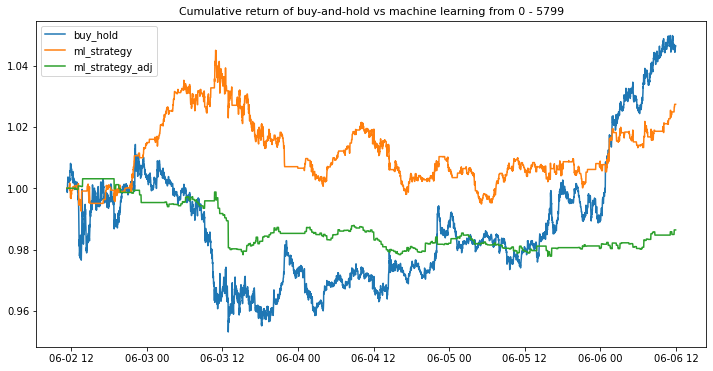

In [341]:
plt.figure(figsize=(12, 6))
plt.plot(backtest_df.Date, backtest_df["buy_hold"])
plt.plot(backtest_df.Date, backtest_df["ml_strategy"])
plt.plot(backtest_df.Date, backtest_df["ml_strategy_adj"])
plt.legend(["buy_hold", "ml_strategy", "ml_strategy_adj"])
plt.title(f"Cumulative return of buy-and-hold vs machine learning from {backtest_df.index[0]} - {backtest_df.index[-1]}", fontsize=11)
plt.show()

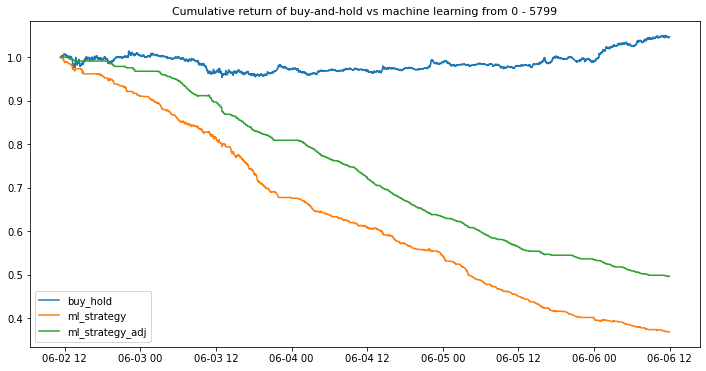

In [342]:
plt.figure(figsize=(12, 6))
plt.plot(backtest_df.Date, backtest_df["buy_hold"])
plt.plot(backtest_df.Date, backtest_df["ml_strategy_net"])
plt.plot(backtest_df.Date, backtest_df["ml_strategy_adj_net"])
plt.legend(["buy_hold", "ml_strategy", "ml_strategy_adj"])
plt.title(f"Cumulative return of buy-and-hold vs machine learning from {backtest_df.index[0]} - {backtest_df.index[-1]}", fontsize=11)
plt.show()

# 6. Store Results Mongo DB

In [225]:
Importance = model.best_estimator_.feature_importances_
df_importance = pd.DataFrame({'Variable': predictors_list_adj, 'Importance':Importance})
df_importance.sort_values(by = ['Importance'], ascending = False, inplace = True)

top_feature_names = list(df_importance.head(10)['Variable'].values)
top_feature_importances = list(np.round(df_importance.head(10)['Importance'],4).values)

In [227]:
df_importance


,Variable,Importance
9,Volume_std_30,0.111138
8,Volume_sma_30,0.100982
1,BBB_120_2.0,0.100084
5,MACDs_15_120_9,0.100016
3,MACD_15_120_9,0.090277
6,ATRr_15,0.089066
7,minute,0.079780
4,MACDh_15_120_9,0.078864
2,BBP_120_2.0,0.077730
0,BBB_15_2.0,0.075891


In [ ]:
min_date, max_date = backtest_df['Date'].min().strftime("%Y-%m-%d"), backtest_df['Date'].max().strftime("%Y-%m-%d")

In [ ]:
max_date

In [ ]:
model_name = 'XGBoost'


backtest_info = { 
            "run_id": "-".join(SYMBOLS) + "-" + model_name + "-" + min_date + "__" + max_date,
            "ticker": "-".join(SYMBOLS), 
            "ptsl" : [str(x) for x in ptsl],
            "v_barrier_minutes": v_barrier_minutes,
            "span_volatility" : span_volatility,
          "model_name": model_name, 
         "model_params": { 'learning_rate' : model.best_estimator_.learning_rate,
                          'max_depth' : model.best_estimator_.max_depth,
                          'n_estimators' : model.best_estimator_.n_estimators
                             }, 
          "feature_importance": {'top_feature_names': [str(x) for x in top_feature_names], 
                                'top_feature_importances': [str(x) for x in top_feature_importances] }, 
         "backtest": {"Date": backtest_df['Date'].astype(str).to_list(),
                      "ml_strategy": backtest_df['ml_strategy'].astype(str).to_list(),
                      "ml_strategy_adj": backtest_df['ml_strategy_adj'].astype(str).to_list(),
                      "buy_hold": backtest_df['buy_hold'].astype(str).to_list(),
                      "pred": backtest_df['pred'].astype(str).to_list(),                      
                     }}


In [ ]:
# import pickle

# with open('backtest.pickle', 'wb') as handle:
#     pickle.dump(backtest_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

import json
config_path = join('../../../../../tensortrader/config.json')
with open(config_path) as f:
    config = json.load(f)

In [ ]:
import pymongo

MONGO_PASSWORD = config['MONGO_PASSWORD']
MONGO_USER = config['MONGO_USER']
MONGO_URL = "mongodb+srv://{}:{}@tensor-database.rjyvv.mongodb.net/?retryWrites=true&w=majority".format(MONGO_USER,MONGO_PASSWORD)

client = pymongo.MongoClient(MONGO_URL)

backtesting_db = client["tensor_models"]
backtesting_collection = backtesting_db["backtesting"]

x = backtesting_collection.insert_one(backtest_info)